# Load

In [49]:
!python --version


Python 3.10.12


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [15]:
df = pd.read_csv('//content/HouseData (1).csv')

In [16]:
df = df.drop(columns=['id'])

In [17]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,zipcode,lat,long
0,20141022T000000,"1,495,000",4,3.25,3070,10375,2.0,No,No View,Average,10,1962,98004,47.5862,-122.198
1,20141126T000000,"1,495,000",4,3.75,3770,4000,2.5,No,No View,Very Good,9,1916,98122,47.6157,-122.287
2,20150129T000000,"1,490,000",4,2.50,2420,18480,1.0,No,No View,Good,9,1967,98004,47.6214,-122.227
3,20150331T000000,"1,490,000",3,3.50,4560,14608,2.0,No,Average,Average,12,1990,98034,47.6995,-122.228
4,20140911T000000,"1,490,000",5,3.50,3620,7821,2.0,No,Average,Average,10,1958,98040,47.5738,-122.215


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21060 entries, 0 to 21059
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         21060 non-null  object 
 1   price        21060 non-null  object 
 2   bedrooms     21060 non-null  int64  
 3   bathrooms    21060 non-null  float64
 4   sqft_living  21060 non-null  int64  
 5   sqft_lot     21060 non-null  int64  
 6   floors       21060 non-null  float64
 7   waterfront   21060 non-null  object 
 8   view         21060 non-null  object 
 9   condition    21060 non-null  object 
 10  grade        21060 non-null  int64  
 11  yr_built     21060 non-null  int64  
 12  zipcode      21060 non-null  int64  
 13  lat          21060 non-null  float64
 14  long         21060 non-null  float64
dtypes: float64(4), int64(6), object(5)
memory usage: 2.4+ MB


# Cleaning

In [19]:
df['date'] = pd.to_datetime(df['date'], format="%Y%m%dT%H%M%S")
df['date_nums'] = df['date'].apply(lambda x: x.timestamp())
df = df.drop(columns=['date'])

In [20]:
df['price'] = df['price'].str.replace(',', '').str.strip()
df['price'] = pd.to_numeric(df['price'], errors='coerce')

In [21]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [22]:
ct = ColumnTransformer(transformers=[ ('encoder', OneHotEncoder(), [6, 7, 8,]) ], remainder='passthrough')
df_transformed = ct.fit_transform(df)

In [23]:
categorical_columns = ['waterfront', 'view', 'condition']
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=False)
df_encoded.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,yr_built,zipcode,lat,long,date_nums,waterfront_No,waterfront_Yes,view_Average,view_Excellent,view_Fair,view_Good,view_No View,condition_Average,condition_Fair- Badly worn,condition_Good,condition_Poor- Worn out,condition_Very Good
0,1495000,4,3.25,3070,10375,2.0,10,1962,98004,47.5862,-122.198,1.413936e+09,True,False,False,False,False,False,True,True,False,False,False,False
1,1495000,4,3.75,3770,4000,2.5,9,1916,98122,47.6157,-122.287,1.416960e+09,True,False,False,False,False,False,True,False,False,False,False,True
2,1490000,4,2.50,2420,18480,1.0,9,1967,98004,47.6214,-122.227,1.422490e+09,True,False,False,False,False,False,True,False,False,True,False,False
3,1490000,3,3.50,4560,14608,2.0,12,1990,98034,47.6995,-122.228,1.427760e+09,True,False,True,False,False,False,False,True,False,False,False,False
4,1490000,5,3.50,3620,7821,2.0,10,1958,98040,47.5738,-122.215,1.410394e+09,True,False,True,False,False,False,False,True,False,False,False,False


In [24]:
def remove_outliers_iqr(df, columns):

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))
        df = df[~outliers]
    return df

columns_to_check = ['sqft_living', 'sqft_lot']

df_encoded = remove_outliers_iqr(df_encoded, columns_to_check)

In [25]:
zip_to_int = {zip_code: i for i, zip_code in enumerate(df_encoded['zipcode'].unique())}
df_encoded['zipcode_num'] = df_encoded['zipcode'].map(zip_to_int)
df_encoded.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,yr_built,zipcode,lat,long,date_nums,waterfront_No,waterfront_Yes,view_Average,view_Excellent,view_Fair,view_Good,view_No View,condition_Average,condition_Fair- Badly worn,condition_Good,condition_Poor- Worn out,condition_Very Good,zipcode_num
0,1495000,4,3.25,3070,10375,2.0,10,1962,98004,47.5862,-122.198,1.413936e+09,True,False,False,False,False,False,True,True,False,False,False,False,0
1,1495000,4,3.75,3770,4000,2.5,9,1916,98122,47.6157,-122.287,1.416960e+09,True,False,False,False,False,False,True,False,False,False,False,True,1
4,1490000,5,3.50,3620,7821,2.0,10,1958,98040,47.5738,-122.215,1.410394e+09,True,False,True,False,False,False,False,True,False,False,False,False,2
7,1485000,4,3.75,4030,10800,2.0,10,2006,98033,47.6821,-122.196,1.402531e+09,True,False,False,False,False,False,True,True,False,False,False,False,3
8,1485000,4,3.25,3730,7200,2.0,10,2006,98033,47.6824,-122.199,1.412122e+09,True,False,False,False,False,False,True,True,False,False,False,False,3


In [26]:
# sns.histplot(df)

# EDA

In [27]:
df_encoded = df_encoded.drop(columns=['zipcode'])

In [28]:
df_encoded.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,yr_built,lat,long,date_nums,waterfront_No,waterfront_Yes,view_Average,view_Excellent,view_Fair,view_Good,view_No View,condition_Average,condition_Fair- Badly worn,condition_Good,condition_Poor- Worn out,condition_Very Good,zipcode_num
price,1.000000,0.288449,0.430607,0.609521,0.006931,0.260755,0.621921,0.000323,0.424028,-0.004673,-0.005436,-0.078652,0.078652,0.164009,0.157366,0.097484,0.166492,-0.292160,-0.008930,-0.063096,-0.027382,-0.026138,0.082618,-0.587202
bedrooms,0.288449,1.000000,0.499776,0.619108,0.202782,0.151631,0.329608,0.160588,-0.042628,0.146097,-0.012594,0.027584,-0.027584,0.039287,0.009541,0.015523,0.028410,-0.052029,-0.000280,-0.047259,-0.006725,-0.028591,0.029577,0.000642
bathrooms,0.430607,0.499776,1.000000,0.708391,-0.019406,0.511692,0.604285,0.533989,-0.009902,0.232817,-0.035273,0.005830,-0.005830,0.063093,0.034560,0.031916,0.069755,-0.104335,0.200270,-0.073588,-0.180516,-0.039382,-0.031953,-0.047493
sqft_living,0.609521,0.619108,0.708391,1.000000,0.218055,0.339947,0.691918,0.327715,0.020174,0.239247,-0.029910,0.000684,-0.000684,0.116834,0.070885,0.067701,0.116302,-0.193091,0.103394,-0.071604,-0.088615,-0.032303,-0.011925,-0.089595
sqft_lot,0.006931,0.202782,-0.019406,0.218055,1.000000,-0.352976,0.063879,-0.042769,-0.141041,0.250509,-0.006099,-0.045355,0.045355,0.031206,0.049067,0.041932,0.031572,-0.072065,-0.171464,0.015977,0.175886,0.007785,0.010843,0.201593
floors,0.260755,0.151631,0.511692,0.339947,-0.352976,1.000000,0.465191,0.507568,0.028278,0.130507,-0.018922,-0.005918,0.005918,-0.004486,0.006732,-0.027222,0.003709,0.011465,0.331321,-0.053592,-0.270037,-0.017903,-0.126003,-0.082182
grade,0.621921,0.329608,0.604285,0.691918,0.063879,0.465191,1.000000,0.466078,0.092344,0.190728,-0.041619,0.001854,-0.001854,0.105530,0.062282,0.042324,0.105354,-0.165607,0.212053,-0.088425,-0.151987,-0.052194,-0.092322,-0.190378
yr_built,0.000323,0.160588,0.533989,0.327715,-0.042769,0.507568,0.466078,1.000000,-0.176858,0.418998,-0.001380,0.029412,-0.029412,-0.055147,-0.034617,-0.036739,-0.032208,0.082808,0.394268,-0.066257,-0.261712,-0.050224,-0.241637,0.219059
lat,0.424028,-0.042628,-0.009902,0.020174,-0.141041,0.028278,0.092344,-0.176858,1.000000,-0.163412,-0.037706,0.020391,-0.020391,0.019692,0.006309,0.015090,0.010592,-0.028082,0.021168,-0.016765,-0.042557,0.003945,0.036235,-0.623877
long,-0.004673,0.146097,0.232817,0.239247,0.250509,0.130507,0.190728,0.418998,-0.163412,1.000000,-0.005385,0.023713,-0.023713,-0.055820,-0.037192,-0.059218,-0.056245,0.105616,0.104653,-0.030682,-0.056537,-0.022427,-0.079766,0.210861


In [29]:
df_encoded.describe().T

,count,mean,std,min,25%,50%,75%,max
price,18480.0,4.814871e+05,2.326068e+05,7.800000e+04,3.100000e+05,4.300000e+05,5.999912e+05,1.495000e+06
bedrooms,18480.0,3.310444e+00,8.718401e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,7.000000e+00
bathrooms,18480.0,2.032495e+00,7.007882e-01,0.000000e+00,1.500000e+00,2.000000e+00,2.500000e+00,5.750000e+00
sqft_living,18480.0,1.916862e+03,7.157068e+02,3.700000e+02,1.370000e+03,1.810000e+03,2.370000e+03,4.110000e+03
sqft_lot,18480.0,7.209560e+03,3.455258e+03,5.200000e+02,4.800000e+03,7.174000e+03,9.223500e+03,1.820500e+04
floors,18480.0,1.479491e+00,5.445034e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,3.500000e+00
grade,18480.0,7.492316e+00,9.951696e-01,3.000000e+00,7.000000e+00,7.000000e+00,8.000000e+00,1.200000e+01
yr_built,18480.0,1.969935e+03,3.001809e+01,1.900000e+03,1.950000e+03,1.971000e+03,1.997000e+03,2.015000e+03
lat,18480.0,4.756157e+01,1.372395e-01,4.715590e+01,4.747727e+01,4.757190e+01,4.767960e+01,4.777760e+01
long,18480.0,-1.222287e+02,1.328145e-01,-1.225120e+02,-1.223370e+02,-1.222670e+02,-1.221520e+02,-1.213150e+02


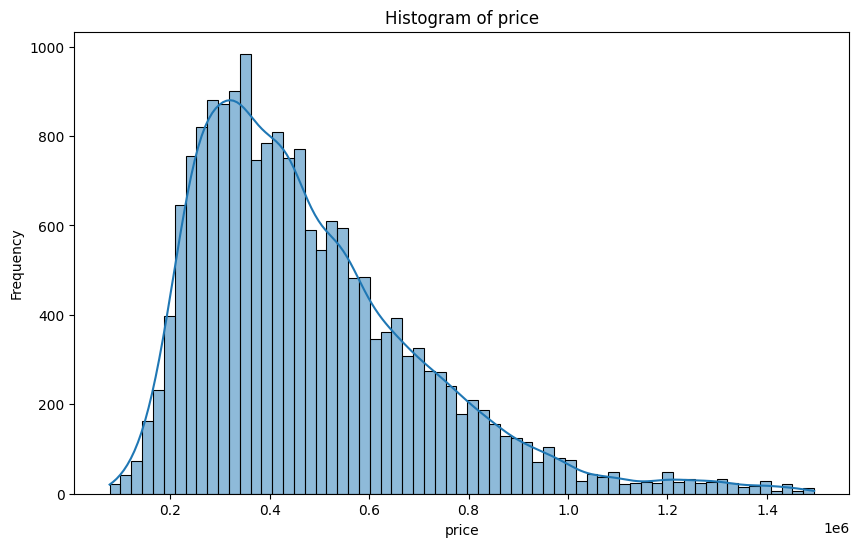

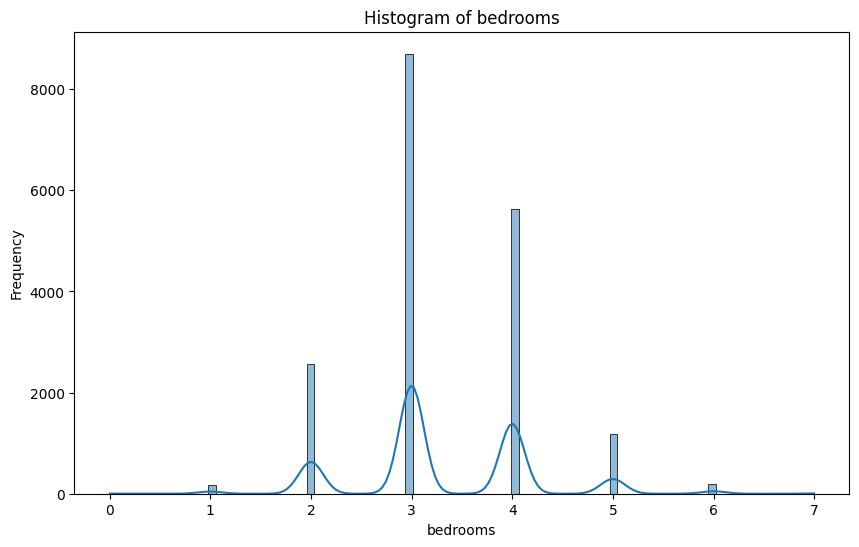

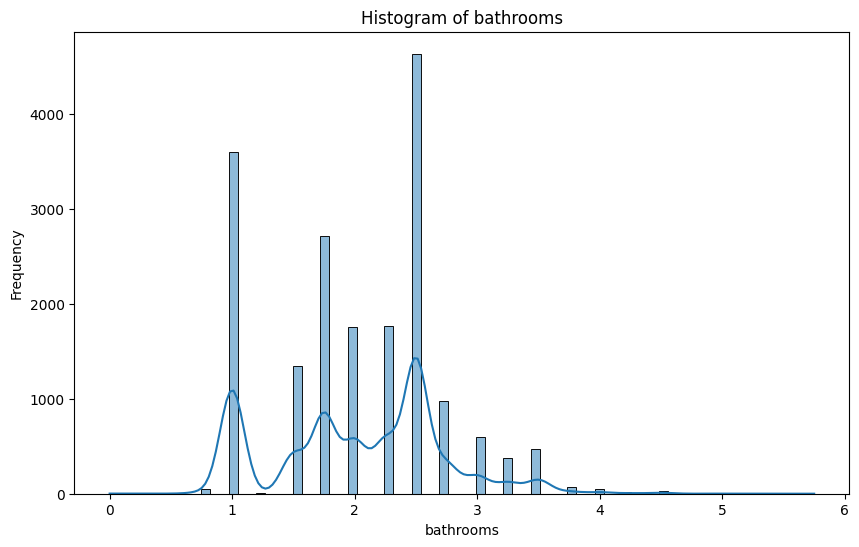

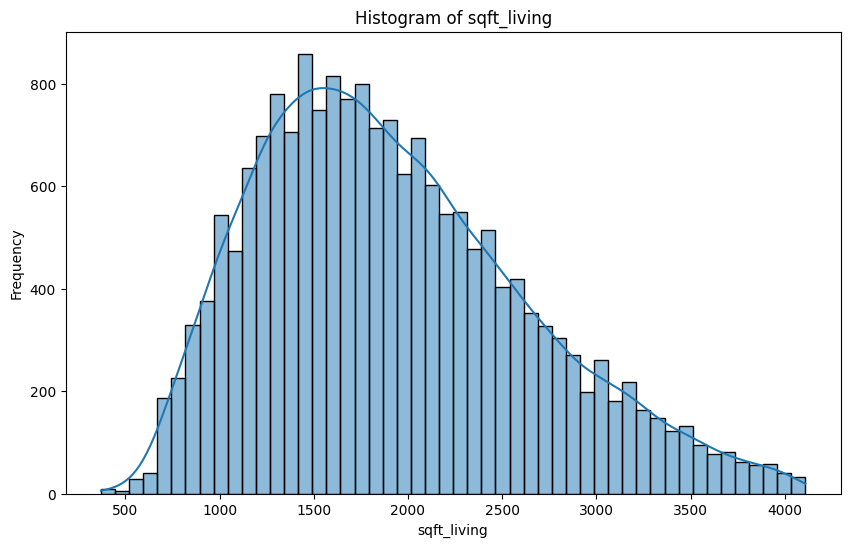

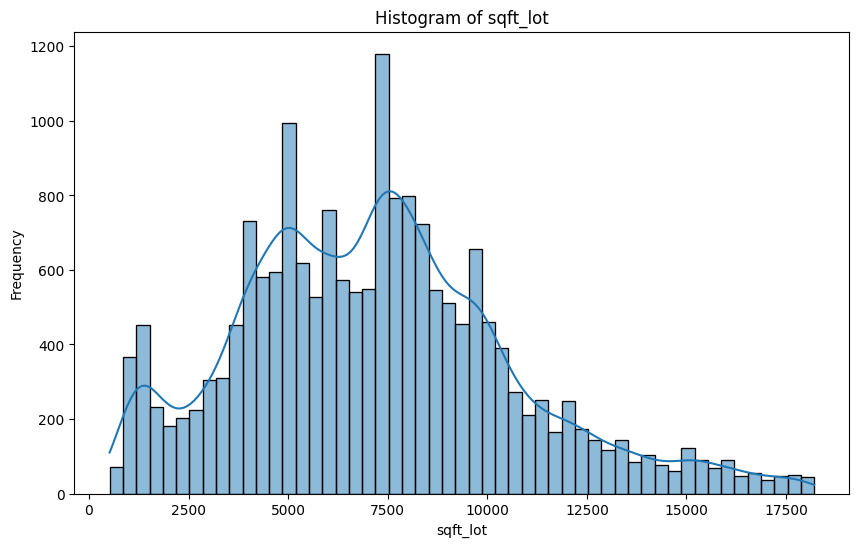

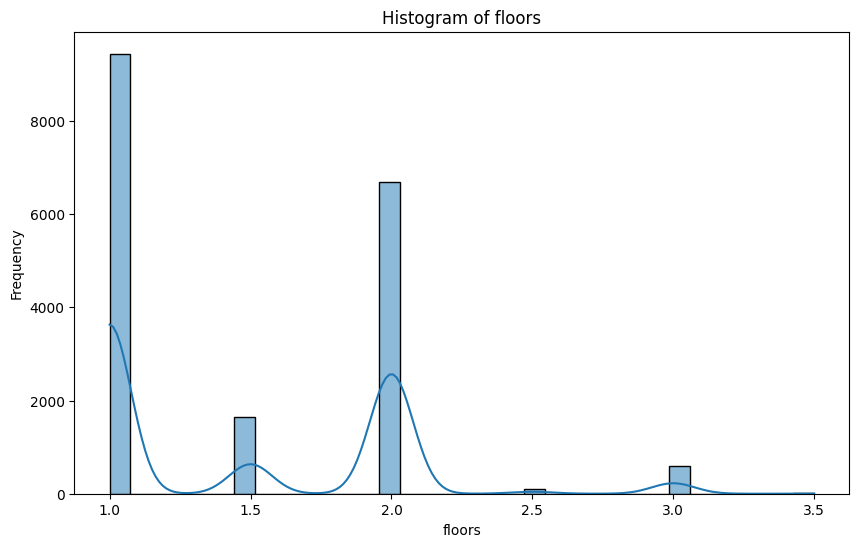

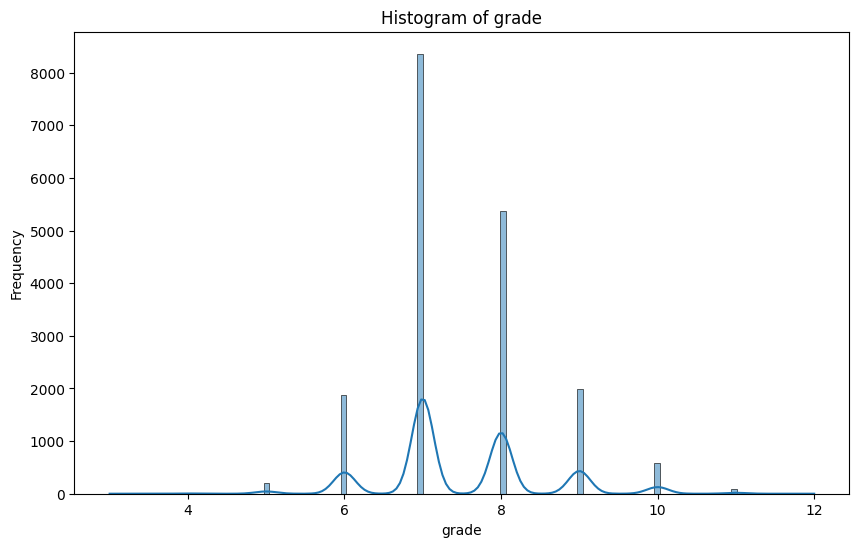

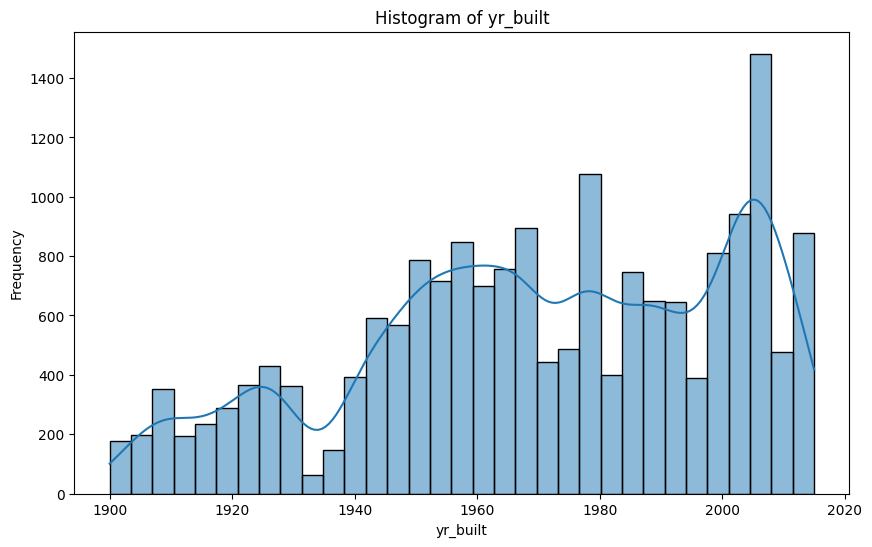

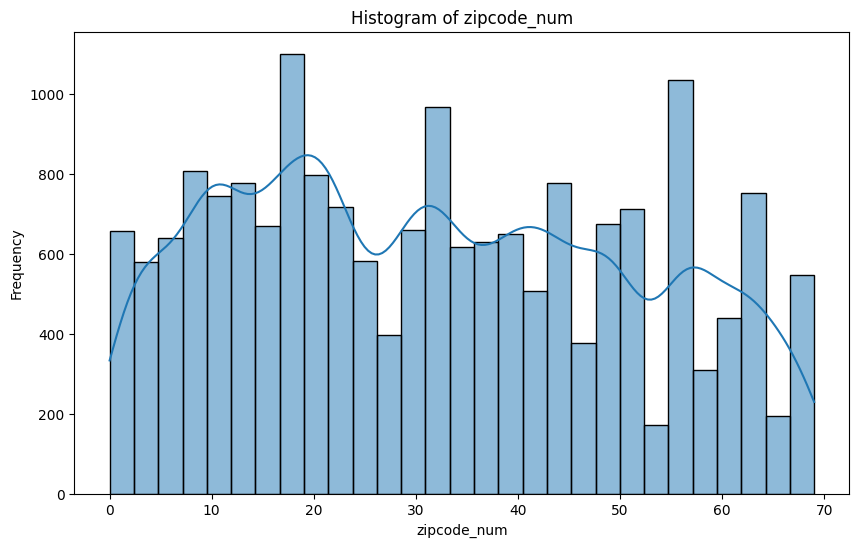

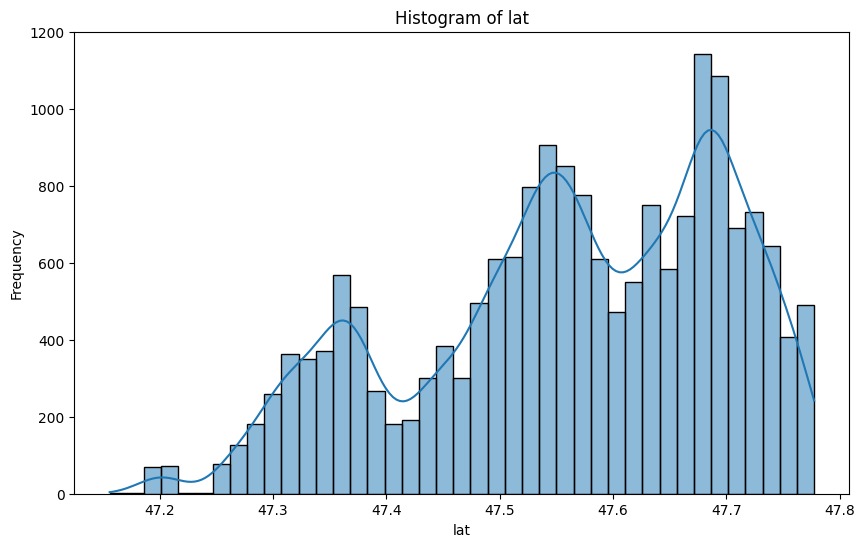

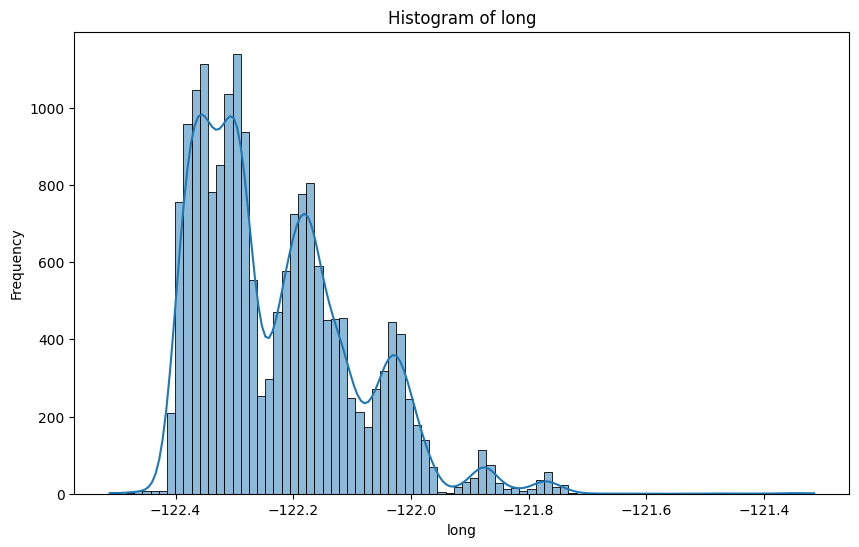

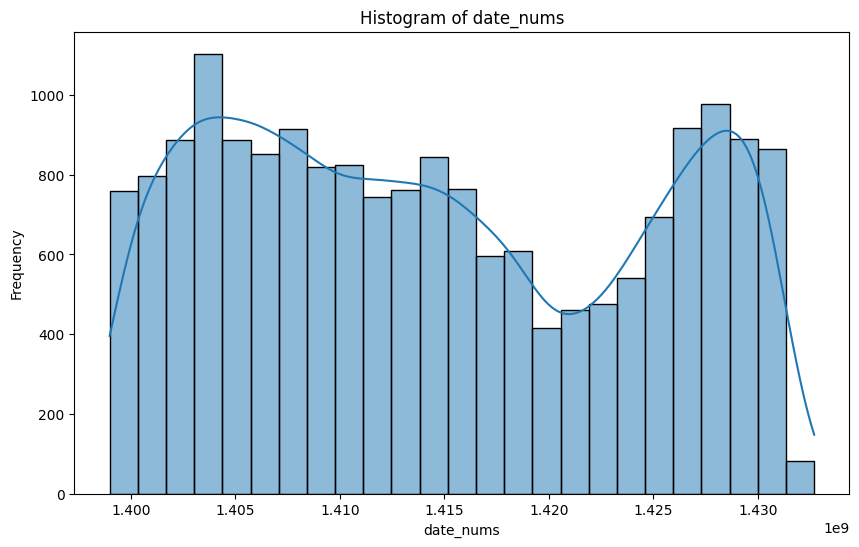

In [30]:
columns_to_plot = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                   'grade', 'yr_built', 'zipcode_num', 'lat', 'long', 'date_nums']

for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_encoded[column], kde=True)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [31]:
correlation_matrix = df_encoded.corr()
price_correlation = correlation_matrix['price'].sort_values(ascending=False)

print(price_correlation)

price                         1.000000
grade                         0.621921
sqft_living                   0.609521
bathrooms                     0.430607
lat                           0.424028
bedrooms                      0.288449
floors                        0.260755
view_Good                     0.166492
view_Average                  0.164009
view_Excellent                0.157366
view_Fair                     0.097484
condition_Very Good           0.082618
waterfront_Yes                0.078652
sqft_lot                      0.006931
yr_built                      0.000323
long                         -0.004673
date_nums                    -0.005436
condition_Average            -0.008930
condition_Poor- Worn out     -0.026138
condition_Good               -0.027382
condition_Fair- Badly worn   -0.063096
waterfront_No                -0.078652
view_No View                 -0.292160
zipcode_num                  -0.587202
Name: price, dtype: float64


<Axes: >

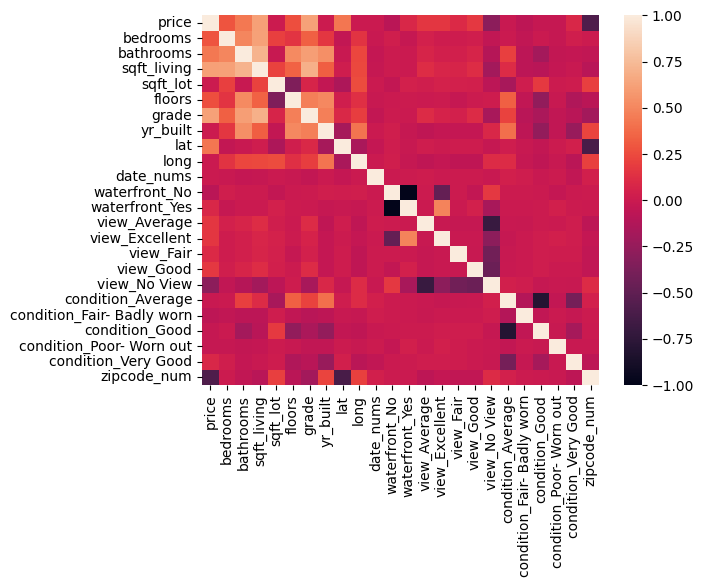

In [32]:
sns.heatmap(df_encoded.corr())


# Model Building

In [33]:
X = df_encoded.drop(columns=['price'])
y = df_encoded['price']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [35]:
model = LinearRegression()
model.fit(X_train, y_train)
np.set_printoptions(precision=2)

y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print(f'r2 Test Score', r2_score(y_test, y_test_pred))
print(f'r2 Train Score', r2_score(y_train, y_train_pred))
print(f'Test Root Mean Squared Error', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print(f'Train Root Mean Squared Error', np.sqrt(mean_squared_error(y_train, y_train_pred)))

r2 Test Score 0.7501071501859535
r2 Train Score 0.7542860487232779
Test Root Mean Squared Error 115776.36524507728
Train Root Mean Squared Error 115420.01120867909


# Tuning

In [36]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)
np.set_printoptions(precision=2)

y_test_pred = model.predict(X_test_poly)
y_train_pred = model.predict(X_train_poly)

print(f'r2 Test Score', r2_score(y_test, y_test_pred))
print(f'r2 Train Score', r2_score(y_train, y_train_pred))
print(f'Test Root Mean Squared Error', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print(f'Train Root Mean Squared Error', np.sqrt(mean_squared_error(y_train, y_train_pred)))

r2 Test Score 0.7880183839459707
r2 Train Score 0.7916579877618468
Test Root Mean Squared Error 106633.11481074856
Train Root Mean Squared Error 106280.75513707816


In [37]:
ridge = Ridge()
parameters = {'alpha': [0.1, 1.0, 10.0, 100.0]}
ridge_reg = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_reg.fit(X_train, y_train)
print(f'Best alpha for Ridge: {ridge_reg.best_params_}')

y_pred_test_ridge = ridge_reg.predict(X_test)
y_pred_train_ridge = ridge_reg.predict(X_train)

ridge_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test_ridge))
ridge_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train_ridge))

print(f'R2 Test Score: {r2_score(y_test, y_pred_test_ridge)}')
print(f'R2 Train Score: {r2_score(y_train, y_pred_train_ridge)}')
print(f'Test Root Mean Squared Error: {ridge_rmse_test}')
print(f'Train Root Mean Squared Error: {ridge_rmse_train}')

Best alpha for Ridge: {'alpha': 1.0}
R2 Test Score: 0.7501265441934428
R2 Train Score: 0.7542849814836079
Test Root Mean Squared Error: 115771.87249695872
Train Root Mean Squared Error: 115420.26186738256


In [38]:
lasso = Lasso()
parameters = {'alpha': [0.01, 0.1, 1.0, 10.0]}
lasso_reg = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_reg.fit(X_train, y_train)
print(f'Best alpha for Lasso: {lasso_reg.best_params_}')

y_pred_test_lasso = lasso_reg.predict(X_test)
y_pred_train_lasso = lasso_reg.predict(X_train)

# Calculate RMSE for test and train sets
lasso_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test_lasso))
lasso_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train_lasso))

# Print the results
print(f'Lasso Test RMSE: {lasso_rmse_test}')
print(f'Lasso Train RMSE: {lasso_rmse_train}')
print(f'R2 Test Score: {r2_score(y_test, y_pred_test_lasso)}')
print(f'R2 Train Score: {r2_score(y_train, y_pred_train_lasso)}')

Best alpha for Lasso: {'alpha': 10.0}
Lasso Test RMSE: 115767.47443101413
Lasso Train RMSE: 115420.70497473581
R2 Test Score: 0.7501455287540015
R2 Train Score: 0.754283094841891


In [39]:
elastic_net = ElasticNet()
parameters = {'alpha': [0.01, 0.1, 1.0, 10.0], 'l1_ratio': [0.1, 0.5, 0.9]}
elastic_net_reg = GridSearchCV(elastic_net, parameters, scoring='neg_mean_squared_error', cv=5)
elastic_net_reg.fit(X_train, y_train)
print(f'Best parameters for Elastic Net: {elastic_net_reg.best_params_}')
y_pred_elastic_net = elastic_net_reg.predict(X_test)
elastic_net_rmse = np.sqrt(mean_squared_error(y_test, y_pred_elastic_net))

y_pred_test_elastic_net = elastic_net_reg.predict(X_test)
y_pred_train_elastic_net = elastic_net_reg.predict(X_train)

elastic_net_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test_elastic_net))
elastic_net_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train_elastic_net))

print(f'Elastic Net Test RMSE: {elastic_net_rmse_test}')
print(f'Elastic Net Train RMSE: {elastic_net_rmse_train}')
print(f'R2 Test Score: {r2_score(y_test, y_pred_test_elastic_net)}')
print(f'R2 Train Score: {r2_score(y_train, y_pred_train_elastic_net)}')

Best parameters for Elastic Net: {'alpha': 0.01, 'l1_ratio': 0.9}
Elastic Net Test RMSE: 115748.94801852504
Elastic Net Train RMSE: 115458.8685254783
R2 Test Score: 0.7502254913969533
R2 Train Score: 0.7541205766889916


In [40]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

parameters = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

xgb_reg = GridSearchCV(xgb_model, parameters, scoring='neg_mean_squared_error', cv=5)
xgb_reg.fit(X_train, y_train)

print(f'Best parameters for XGBoost: {xgb_reg.best_params_}')

y_pred_test_xgb = xgb_reg.predict(X_test)
y_pred_train_xgb = xgb_reg.predict(X_train)

xgb_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
xgb_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))

print(f'XGBoost Test RMSE: {xgb_rmse_test}')
print(f'XGBoost Train RMSE: {xgb_rmse_train}')
print(f'R2 Test Score: {r2_score(y_test, y_pred_test_xgb)}')
print(f'R2 Train Score: {r2_score(y_train, y_pred_train_xgb)}')

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
XGBoost Test RMSE: 78558.66264099823
XGBoost Train RMSE: 54417.15810101999
R2 Test Score: 0.8849458810559823
R2 Train Score: 0.9453815581971329


# Final Model

R2 Test Score: 0.8747926359373386
R2 Train Score: 0.9054551439472952
Test Root Mean Squared Error: 81951.69346319568
Train Root Mean Squared Error: 71595.40608709618
Mean Absolute Error: 6716080061.48559


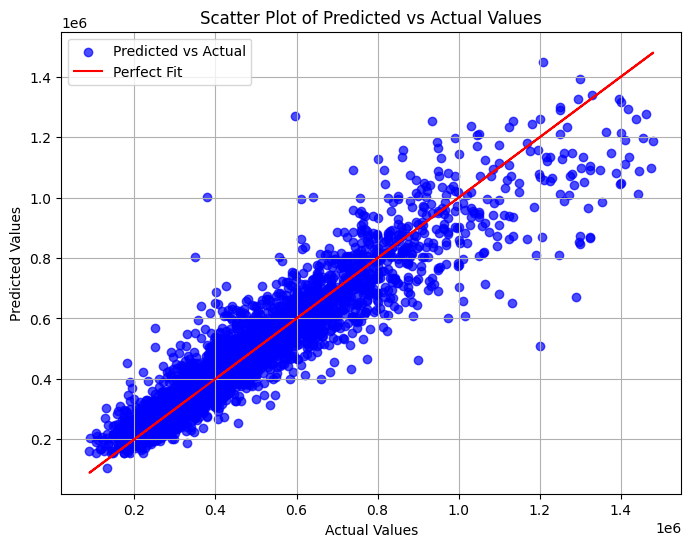

Test RMSE: 81951.69346319568


,Actual,Predicted,Difference,% Difference
14351,350000,2.988462e+05,-51153.781250,-14.615366
20442,190000,3.269888e+05,136988.750000,72.099342
18851,247200,2.635023e+05,16302.281250,6.594774
11348,425000,4.282178e+05,3217.812500,0.757132
18528,254950,2.441542e+05,-10795.765625,-4.234464
5124,630000,6.928122e+05,62812.187500,9.970188
9734,465000,4.264961e+05,-38503.906250,-8.280410
8490,502000,4.772431e+05,-24756.875000,-4.931648
12468,398000,4.607472e+05,62747.218750,15.765633
8463,504058,5.077242e+05,3666.156250,0.727328


In [41]:
best_params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}

xgb_model = xgb.XGBRegressor(learning_rate=best_params['learning_rate'], max_depth=best_params['max_depth'], n_estimators=best_params['n_estimators'] )
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

np.set_printoptions(precision=2)

mse_test = mean_squared_error(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)

print(f'R2 Test Score: {r2_test}')
print(f'R2 Train Score: {r2_train}')
print(f'Test Root Mean Squared Error: {np.sqrt(mse_test)}')
print(f'Train Root Mean Squared Error: {np.sqrt(mse_train)}')

comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred,
    'Difference': y_test_pred - y_test,
    '% Difference': ((y_test_pred - y_test) / y_test) * 100
})

mae_test = mean_squared_error(y_test, y_test_pred)
print(f'Mean Absolute Error: {mae_test}')

actual_values = comparison_df['Actual']
predicted_values = comparison_df['Predicted']

plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, alpha=0.7, color='b', label='Predicted vs Actual')
plt.plot(actual_values, actual_values, color='r', label='Perfect Fit')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

comparison_df

# Predictor

In [42]:
print(f'Predictor array')
df_predictor = df_encoded.drop(columns=['price'])
df_predictor.head(1)

Predictor array


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,yr_built,lat,long,date_nums,waterfront_No,waterfront_Yes,view_Average,view_Excellent,view_Fair,view_Good,view_No View,condition_Average,condition_Fair- Badly worn,condition_Good,condition_Poor- Worn out,condition_Very Good,zipcode_num
0,4,3.25,3070,10375,2.0,10,1962,47.5862,-122.198,1.413936e+09,True,False,False,False,False,False,True,True,False,False,False,False,0


In [43]:
xgb_model.predict([(4,	3.25,	3070,	10375,	2.0,	10,	1962,	98004,	47.5862,	-122.198,	1.413936e+09,	True,	False,	False,	False,	False,	False,	True,	True,	False,	False,	False,	False,)])

array([816253.5], dtype=float32)

In [44]:
xgb_model.predict([(
    4,
    3.25,
    3070,
    10375,
    2.0,
    10,
    1962,
    98004,
    47.5862,
    -122.198,
    1.413936e+09,
    True,
    False,
    False,
    False,
    False,
    False,
    True,
    True,
    False,
    False,
    False,
    False,
)])

array([816253.5], dtype=float32)

In [46]:
df_encoded.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,yr_built,lat,long,date_nums,waterfront_No,waterfront_Yes,view_Average,view_Excellent,view_Fair,view_Good,view_No View,condition_Average,condition_Fair- Badly worn,condition_Good,condition_Poor- Worn out,condition_Very Good,zipcode_num
0,1495000,4,3.25,3070,10375,2.0,10,1962,47.5862,-122.198,1.413936e+09,True,False,False,False,False,False,True,True,False,False,False,False,0
1,1495000,4,3.75,3770,4000,2.5,9,1916,47.6157,-122.287,1.416960e+09,True,False,False,False,False,False,True,False,False,False,False,True,1
4,1490000,5,3.50,3620,7821,2.0,10,1958,47.5738,-122.215,1.410394e+09,True,False,True,False,False,False,False,True,False,False,False,False,2
7,1485000,4,3.75,4030,10800,2.0,10,2006,47.6821,-122.196,1.402531e+09,True,False,False,False,False,False,True,True,False,False,False,False,3
8,1485000,4,3.25,3730,7200,2.0,10,2006,47.6824,-122.199,1.412122e+09,True,False,False,False,False,False,True,True,False,False,False,False,3
